# XMM-LSS master catalogue - IRAC merging

This notebook presents the merge of the IRAC pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
candels = Table.read("{}/CANDELS-UDS.fits".format(TMP_DIR))           # 1.2

#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6

servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7

#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances separating the sources from one catalogue to the other (within a maximum radius) to determine the best cross-matching radius.

### Start with CANDELS

In [5]:
master_catalogue = candels
master_catalogue['candels_ra'].name = 'ra'
master_catalogue['candels_dec'].name = 'dec'
del candels
unused_bands = [ 'candels-megacam', 'candels-ukidss', 'hawki', 'suprime', 'wfc3', 'acs']
for col in master_catalogue.colnames:
    
    for band in unused_bands:
        if band in col:
            master_catalogue.remove_column(col)
            print(col, ' removed.')

f_acs_f606w  removed.
ferr_acs_f606w  removed.
f_ap_acs_f606w  removed.
ferr_ap_acs_f606w  removed.
f_acs_f814w  removed.
ferr_acs_f814w  removed.
f_ap_acs_f814w  removed.
ferr_ap_acs_f814w  removed.
f_wfc3_f125w  removed.
ferr_wfc3_f125w  removed.
f_ap_wfc3_f125w  removed.
ferr_ap_wfc3_f125w  removed.
f_wfc3_f160w  removed.
ferr_wfc3_f160w  removed.
f_ap_wfc3_f160w  removed.
ferr_ap_wfc3_f160w  removed.
f_candels-megacam_u  removed.
ferr_candels-megacam_u  removed.
f_suprime_b  removed.
ferr_suprime_b  removed.
f_suprime_v  removed.
ferr_suprime_v  removed.
f_suprime_rc  removed.
ferr_suprime_rc  removed.
f_suprime_ip  removed.
ferr_suprime_ip  removed.
f_suprime_zp  removed.
ferr_suprime_zp  removed.
f_hawki_k  removed.
ferr_hawki_y  removed.
ferr_hawki_k  removed.
f_candels-ukidss_j  removed.
ferr_candels-ukidss_j  removed.
f_candels-ukidss_h  removed.
ferr_candels-ukidss_h  removed.
f_candels-ukidss_k  removed.
ferr_candels-ukidss_k  removed.
m_acs_f606w  removed.
merr_acs_f606w  r

### Add SERVS

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(servs['servs_ra'], servs['servs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [7]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, servs, "servs_ra", "servs_dec", radius=1.*u.arcsec)

### Add SWIRE

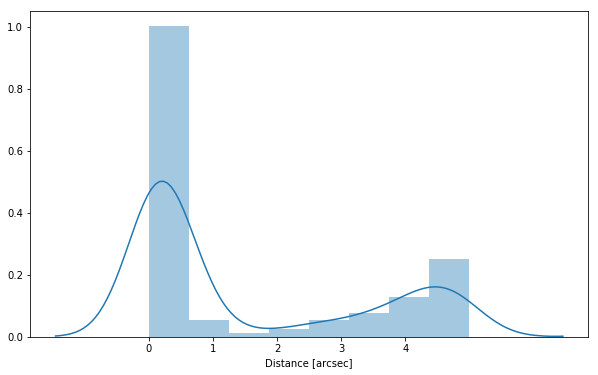

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(swire['swire_ra'], swire['swire_dec'])
)

In [9]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, swire, "swire_ra", "swire_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [10]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [11]:
#Since this is not the final merged catalogue. We rename column names to make them unique
master_catalogue['ra'].name = 'irac_ra'
master_catalogue['dec'].name = 'irac_dec'
master_catalogue['flag_merged'].name = 'irac_flag_merged'

In [12]:
master_catalogue[:10].show_in_notebook()

idx,candels_id,irac_ra,irac_dec,candels_stellarity,f_candels-irac_i1,ferr_candels-irac_i1,f_candels-irac_i2,ferr_candels-irac_i2,f_candels-irac_i3,ferr_candels-irac_i3,f_candels-irac_i4,ferr_candels-irac_i4,m_candels-irac_i1,merr_candels-irac_i1,flag_candels-irac_i1,m_candels-irac_i2,merr_candels-irac_i2,flag_candels-irac_i2,m_candels-irac_i3,merr_candels-irac_i3,flag_candels-irac_i3,m_candels-irac_i4,merr_candels-irac_i4,flag_candels-irac_i4,candels_flag_cleaned,candels_flag_gaia,irac_flag_merged,servs_intid,f_ap_servs_irac_i1,ferr_ap_servs_irac_i1,f_servs_irac_i1,ferr_servs_irac_i1,servs_stellarity_irac_i1,f_ap_servs_irac_i2,ferr_ap_servs_irac_i2,f_servs_irac_i2,ferr_servs_irac_i2,servs_stellarity_irac_i2,m_ap_servs_irac_i1,merr_ap_servs_irac_i1,m_servs_irac_i1,merr_servs_irac_i1,flag_servs_irac_i1,m_ap_servs_irac_i2,merr_ap_servs_irac_i2,m_servs_irac_i2,merr_servs_irac_i2,flag_servs_irac_i2,servs_flag_cleaned,servs_flag_gaia,swire_intid,f_ap_swire_irac_i1,ferr_ap_swire_irac_i1,f_swire_irac_i1,ferr_swire_irac_i1,swire_stellarity_irac_i1,f_ap_swire_irac_i2,ferr_ap_swire_irac_i2,f_swire_irac_i2,ferr_swire_irac_i2,swire_stellarity_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_irac_i3,ferr_irac_i3,swire_stellarity_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,f_irac_i4,ferr_irac_i4,swire_stellarity_irac_i4,m_ap_swire_irac_i1,merr_ap_swire_irac_i1,m_swire_irac_i1,merr_swire_irac_i1,flag_swire_irac_i1,m_ap_swire_irac_i2,merr_ap_swire_irac_i2,m_swire_irac_i2,merr_swire_irac_i2,flag_swire_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_irac_i3,merr_irac_i3,flag_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,m_irac_i4,merr_irac_i4,flag_irac_i4,swire_flag_cleaned,swire_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,
0,35489,34.4574665693,-5.12505315973,0.810000002384,-0.0050759,0.0137912,-0.0329934,0.0183968,0.4991309,0.5398261,-0.1158999,0.6673397,nan,-2.94994092615,False,nan,-0.605395982581,False,24.6544638579,1.17425857835,False,nan,-6.25155736254,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
1,27199,34.3561903693,-5.27671705973,0.980000019073,0.2334918,0.0408433,0.1624291,0.0514223,-0.6488702,1.0783935,0.4441419,1.3083811,25.4793209171,0.189921228633,False,25.8733404051,0.343725679955,False,nan,-1.80444542826,False,24.7811956347,3.19842989344,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
2,72,34.4389173693,-5.27655485973,0.00999999977648,0.3079384,0.0454404,0.3070924,0.0587367,0.769,1.3464183,0.0871364,1.6068749,25.1788403777,0.160214794383,False,25.1818273286,0.207665711486,False,24.1851841505,1.90098191815,False,26.5495009668,20.0219684936,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
3,29734,34.3542499693,-5.23240925973,0.829999983311,0.0084598,0.0512751,0.0998262,0.0589584,-0.4559857,1.5066038,-3.7248702,1.7440617,29.0815997602,6.58067950455,False,26.4018886512,0.641247182149,False,nan,-3.58733682194,False,nan,-0.508364272941,False,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan

In [13]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['servs_intid'].astype(str)) 
                                    +  np.char.array(master_catalogue['swire_intid'].astype(str) )
                                         +  np.char.array(master_catalogue['candels_id'].astype(str) )), 
                              name="irac_intid"))

In [14]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['candels_id', 'servs_intid', 'swire_intid', 'irac_intid']


## VII - Choosing between multiple values for the same filter



### VII.a SERVS and SWIRE IRAC fluxes

Both SERVS and SWIRE provide IRAC1 and IRAC2 fluxes. SERVS is deeper but tends to under-estimate flux of bright sources (Mattia said over 2000 µJy) as illustrated by this comparison of SWIRE, SERVS, and Spitzer-EIP fluxes. we include CANDELS fluxes where no other flux is available. CANDELS includes all four IRAC bands.

In [15]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_XMM-LSS.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['irac_ra'], master_catalogue['irac_dec']))
mask = d2d <= 2 * u.arcsec

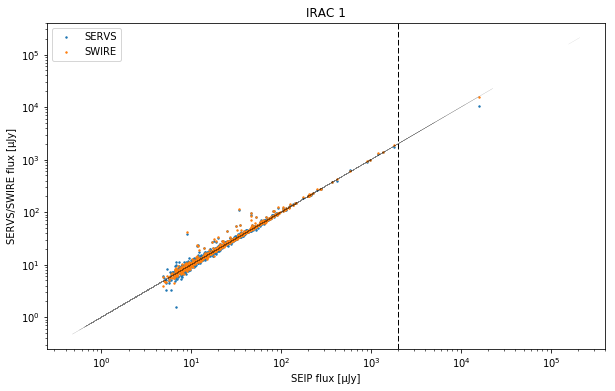

In [16]:
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i1'], label="SERVS", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i1'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

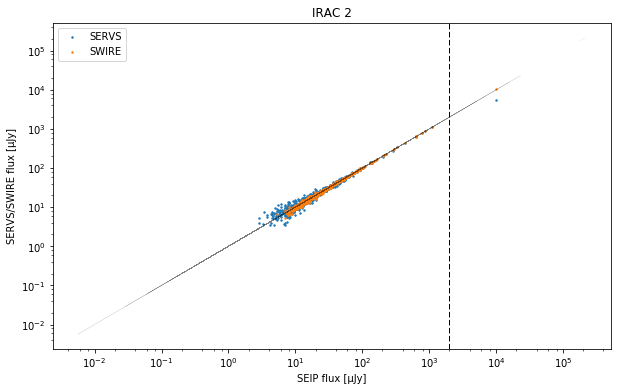

In [17]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i2'], label="SERVS", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i2'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SWIRE and SERVS fluxes are provided, we use the SERVS flux below 2000 μJy and the SWIRE flux over.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [18]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['irac_intid'])

In [19]:
# IRAC1 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_servs_irac_i1', 'f_ap_swire_irac_i1', 'ferr_ap_servs_irac_i1',
                                     'ferr_ap_swire_irac_i1', 'm_ap_servs_irac_i1', 'm_ap_swire_irac_i1',
                                     'merr_ap_servs_irac_i1', 'merr_ap_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_app"))

1776 sources with SERVS flux
735 sources with SWIRE flux
660 sources with SERVS and SWIRE flux
1775 sources for which we use SERVS
76 sources for which we use SWIRE


In [20]:
# IRAC1 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i1'])
has_both = has_servs & has_swire
has_candels = ~np.isnan(master_catalogue['f_candels-irac_i1'])

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))
print("{} sources with CANDELS flux".format(np.sum(has_candels)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))
use_candels = has_candels & ~has_servs & ~has_swire

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))
print("{} sources for which we use CANDELS".format(np.sum(use_candels)))

f_irac_i = np.full(len(master_catalogue), np.nan)
f_irac_i[use_servs] = master_catalogue['f_servs_irac_i1'][use_servs]
f_irac_i[use_swire] = master_catalogue['f_swire_irac_i1'][use_swire]
f_irac_i[use_candels] = master_catalogue['f_candels-irac_i1'][use_candels]

ferr_irac_i = np.full(len(master_catalogue), np.nan)
ferr_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i1'][use_servs]
ferr_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i1'][use_swire]
ferr_irac_i[use_candels] = master_catalogue['ferr_candels-irac_i1'][use_candels]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i1'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i1'][use_swire]
flag_irac_i[use_candels] = master_catalogue['flag_candels-irac_i1'][use_candels]

m_irac_i = np.full(len(master_catalogue), np.nan)
m_irac_i[use_servs] = master_catalogue['m_servs_irac_i1'][use_servs]
m_irac_i[use_swire] = master_catalogue['m_swire_irac_i1'][use_swire]
m_irac_i[use_candels] = master_catalogue['m_candels-irac_i1'][use_candels]

merr_irac_i = np.full(len(master_catalogue), np.nan)
merr_irac_i[use_servs] = master_catalogue['merr_servs_irac_i1'][use_servs]
merr_irac_i[use_swire] = master_catalogue['merr_swire_irac_i1'][use_swire]
merr_irac_i[use_candels] = master_catalogue['merr_candels-irac_i1'][use_candels]

master_catalogue.add_column(Column(data=f_irac_i, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_irac_i, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_irac_i, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_irac_i, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_servs_irac_i1', 'f_swire_irac_i1', 'f_candels-irac_i1',
                                 'ferr_servs_irac_i1','ferr_swire_irac_i1', 'ferr_candels-irac_i1',
                                 'm_servs_irac_i1', 'm_swire_irac_i1', 'm_candels-irac_i1',
                                 'merr_servs_irac_i1', 'merr_swire_irac_i1', 'merr_candels-irac_i1', 
                                 'flag_servs_irac_i1', 'flag_swire_irac_i1', 'flag_candels-irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
origin[use_candels] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

1776 sources with SERVS flux
735 sources with SWIRE flux
660 sources with SERVS and SWIRE flux
35931 sources with CANDELS flux
1775 sources for which we use SERVS
76 sources for which we use SWIRE
35931 sources for which we use CANDELS


In [21]:
# IRAC2 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_servs_irac_i2', 'f_ap_swire_irac_i2', 'ferr_ap_servs_irac_i2',
                                 'ferr_ap_swire_irac_i2', 'm_ap_servs_irac_i2', 'm_ap_swire_irac_i2',
                                 'merr_ap_servs_irac_i2', 'merr_ap_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_app"))

1856 sources with SERVS flux
507 sources with SWIRE flux
486 sources with SERVS and SWIRE flux
1855 sources for which we use SERVS
22 sources for which we use SWIRE


In [22]:
# IRAC2 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i2'])
has_both = has_servs & has_swire
has_candels = ~np.isnan(master_catalogue['f_candels-irac_i2'])

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))
print("{} sources with CANDELS flux".format(np.sum(has_candels)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))
use_candels = has_candels & ~has_servs & ~has_swire

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))
print("{} sources for which we use CANDELS".format(np.sum(use_candels)))

f_irac_i = np.full(len(master_catalogue), np.nan)
f_irac_i[use_servs] = master_catalogue['f_servs_irac_i2'][use_servs]
f_irac_i[use_swire] = master_catalogue['f_swire_irac_i2'][use_swire]
f_irac_i[use_candels] = master_catalogue['f_candels-irac_i2'][use_candels]

ferr_irac_i = np.full(len(master_catalogue), np.nan)
ferr_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i2'][use_servs]
ferr_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i2'][use_swire]
ferr_irac_i[use_candels] = master_catalogue['ferr_candels-irac_i2'][use_candels]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i2'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i2'][use_swire]
flag_irac_i[use_candels] = master_catalogue['flag_candels-irac_i2'][use_candels]

m_irac_i = np.full(len(master_catalogue), np.nan)
m_irac_i[use_servs] = master_catalogue['m_servs_irac_i2'][use_servs]
m_irac_i[use_swire] = master_catalogue['m_swire_irac_i2'][use_swire]
m_irac_i[use_candels] = master_catalogue['m_candels-irac_i2'][use_candels]

merr_irac_i = np.full(len(master_catalogue), np.nan)
merr_irac_i[use_servs] = master_catalogue['merr_servs_irac_i2'][use_servs]
merr_irac_i[use_swire] = master_catalogue['merr_swire_irac_i2'][use_swire]
merr_irac_i[use_candels] = master_catalogue['merr_candels-irac_i2'][use_candels]

master_catalogue.add_column(Column(data=f_irac_i, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_irac_i, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_irac_i, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_irac_i, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_servs_irac_i2', 'f_swire_irac_i2', 'f_candels-irac_i2',
                                 'ferr_servs_irac_i2','ferr_swire_irac_i2', 'ferr_candels-irac_i2',
                                 'm_servs_irac_i2', 'm_swire_irac_i2', 'm_candels-irac_i2',
                                 'merr_servs_irac_i2', 'merr_swire_irac_i2', 'merr_candels-irac_i2', 
                                 'flag_servs_irac_i2', 'flag_swire_irac_i2', 'flag_candels-irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
origin[use_candels] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

1856 sources with SERVS flux
507 sources with SWIRE flux
486 sources with SERVS and SWIRE flux
35931 sources with CANDELS flux
1855 sources for which we use SERVS
22 sources for which we use SWIRE
35931 sources for which we use CANDELS


In [23]:
has_candels_irac_i3 = ~np.isnan(master_catalogue['f_candels-irac_i3'])
has_candels_irac_i4 = ~np.isnan(master_catalogue['f_candels-irac_i4'])
has_swire_irac_i3 = ~np.isnan(master_catalogue['f_irac_i3'])
has_swire_irac_i4 = ~np.isnan(master_catalogue['f_irac_i4'])

use_candels_irac_i3 = has_candels_irac_i3 & ~has_swire_irac_i3
use_candels_irac_i4 = has_candels_irac_i4 & ~has_swire_irac_i4

master_catalogue['f_irac_i3'][use_candels_irac_i3] = master_catalogue['f_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['ferr_irac_i3'][use_candels_irac_i3] = master_catalogue['ferr_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['m_irac_i3'][use_candels_irac_i3] = master_catalogue['m_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['merr_irac_i3'][use_candels_irac_i3] = master_catalogue['merr_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['flag_irac_i3'][use_candels_irac_i3] = master_catalogue['flag_candels-irac_i3'][use_candels_irac_i3]

master_catalogue['f_irac_i4'][use_candels_irac_i3] = master_catalogue['f_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['ferr_irac_i4'][use_candels_irac_i3] = master_catalogue['ferr_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['m_irac_i4'][use_candels_irac_i3] = master_catalogue['m_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['merr_irac_i4'][use_candels_irac_i3] = master_catalogue['merr_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['flag_irac_i4'][use_candels_irac_i3] = master_catalogue['flag_candels-irac_i4'][use_candels_irac_i3]

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_swire_irac_i3] = "SWIRE"
origin[use_candels_irac_i3] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC3_total"))

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_swire_irac_i4] = "SWIRE"
origin[use_candels_irac_i4] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC4_total"))

master_catalogue.remove_columns(['f_candels-irac_i3',    'f_candels-irac_i4',
                                 'ferr_candels-irac_i3', 'ferr_candels-irac_i4',
                                 'm_candels-irac_i3',    'm_candels-irac_i4',
                                 'merr_candels-irac_i3', 'merr_candels-irac_i4',
                                 'flag_candels-irac_i3', 'flag_candels-irac_i4'])

In [24]:
irac_origin.write("{}/xmm-lss_irac_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XI - Saving the catalogue

In [25]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", 
            "flag_gaia", "flag_optnir_obs", "flag_optnir_det" 
            ]

In [26]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'servs_flag_gaia', 'candels_id', 'swire_flag_cleaned', 'servs_stellarity_irac_i2', 'candels_flag_gaia', 'swire_intid', 'servs_stellarity_irac_i1', 'swire_flag_gaia', 'swire_stellarity_irac_i1', 'servs_intid', 'irac_flag_merged', 'irac_dec', 'servs_flag_cleaned', 'swire_stellarity_irac_i4', 'swire_stellarity_irac_i3', 'swire_stellarity_irac_i2', 'irac_ra', 'irac_intid', 'candels_stellarity', 'candels_flag_cleaned'}


In [27]:
master_catalogue.write("{}/irac_merged_catalogue_xmm-lss.fits".format(TMP_DIR), overwrite=True)